In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings # hii niliona kwa checkpoint ni kacopy kuondoa warnings :)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('clean_full_movie_data.csv')
df

,movie_titles,genres,original_language,release_date,studio,production_budget,domestic_gross,foreign_gross,worldwide_gross,revenue,runtime,popularity,production_companies,production_countries,vote_average,vote_count
0,toy story 3,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",en,2010-06-16,BV,200000000,"$415,004,880",652000000,"$1,068,879,522",1066969703,103.0,16.966470,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",7.6,4710.0
1,inception,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",en,2010-07-14,WB,160000000,"$292,576,195",535700000,"$835,524,642",825532764,148.0,29.108149,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",8.1,14075.0
2,shrek forever after,"[{'id': 35, 'name': 'Comedy'}, {'id': 12, 'nam...",en,2010-05-16,P/DW,165000000,"$238,736,787",513900000,"$756,244,673",752600867,93.0,11.803808,"[{'name': 'DreamWorks Animation', 'id': 521}]","[{'iso_3166_1': 'US', 'name': 'United States o...",6.0,2021.0
3,the twilight saga: eclipse,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,2010-06-23,Sum.,68000000,"$300,531,751",398000000,"$706,102,828",698491347,124.0,34.047399,"[{'name': 'Summit Entertainment', 'id': 491}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",5.9,2382.0
4,iron man 2,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",en,2010-04-28,Par.,200000000,"$312,433,331",311500000,"$621,156,389",623933331,124.0,19.083344,"[{'name': 'Marvel Studios', 'id': 420}]","[{'iso_3166_1': 'US', 'name': 'United States o...",6.6,6969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45744,stories of our lives,"[{""id"": 18, ""name"": ""Drama""}]",en,2014-09-05,NaN,0,NaN,NaN,NaN,0,60.0,0.327794,[],"[{""iso_3166_1"": ""KE"", ""name"": ""Kenya""}]",0.0,0.0
45745,tin can man,"[{""id"": 27, ""name"": ""Horror""}]",en,2007-01-01,NaN,13,NaN,NaN,NaN,0,84.0,0.332679,"[{""name"": ""Park Films"", ""id"": 21871}, {""name"":...","[{""iso_3166_1"": ""IE"", ""name"": ""Ireland""}]",2.0,1.0
45746,on the downlow,"[{""id"": 18, ""name"": ""Drama""}]",en,2004-04-11,NaN,0,NaN,NaN,NaN,0,90.0,0.029757,"[{""name"": ""Iconoclast Films"", ""id"": 26677}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",6.0,2.0
45747,sanctuary: quite a conundrum,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 27, ""n...",en,2012-01-20,NaN,0,NaN,NaN,NaN,0,82.0,0.166513,"[{""name"": ""Gold Lion Films"", ""id"": 37870}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",0.0,0.0


In [3]:
df.isna().sum()

movie_titles                1
genres                    146
original_language         157
release_date                1
studio                  44280
production_budget           1
domestic_gross          44279
foreign_gross           44475
worldwide_gross         44279
revenue                     1
runtime                   394
popularity                146
production_companies      146
production_countries      146
vote_average              146
vote_count                146
dtype: int64

In [5]:
# Since revenue is the same as gross we will drop the domestic, foreign and worldwide gross columns since they have alot of missing values and the revenue column has less missing vvalues
#Drop all the columns not needed in this analysis.
columns_to_drop = [
    'domestic_gross',
    'foreign_gross',
    'worldwide_gross',
    'studio',
    'original_language',
]
df = df.drop(columns=columns_to_drop)

In [6]:
df.isna().sum()

movie_titles              1
genres                  146
release_date              1
production_budget         1
revenue                   1
runtime                 394
popularity              146
production_companies    146
production_countries    146
vote_average            146
vote_count              146
dtype: int64

In [7]:
# Convert all values to string, then remove $ and comma, and finally convert to numeric
def clean_currency_column(series):
    cleaned_series = series.astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
    return pd.to_numeric(cleaned_series, errors='coerce')


# Parse JSON-like string in the 'genres' column
def extract_genre_names(genres_str):
    if pd.isna(genres_str) or genres_str in ('[]', ''):
        return []
    try:
        # Use simple string replacement to fix single quotes to double quotes for valid JSON
        genres_str_fixed = genres_str.replace("'", '"')
        genres_list = json.loads(genres_str_fixed)
        return [g['name'] for g in genres_list]
    except (TypeError, json.JSONDecodeError):
        return []

In [8]:
df['revenue'] = clean_currency_column(df['revenue']) # Worldwide revenue
df['production_budget'] = clean_currency_column(df['production_budget']) # Production budget
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce') # Ratings


# Calculate Profit
df['profit'] = df['revenue'] - df['production_budget']

# Drop rows where key financial data is missing or zero (not reliable for profit/revenue analysis)
df.dropna(subset=['revenue', 'production_budget', 'profit', 'vote_average'], inplace=True)
df = df[(df['revenue'] > 1e4) & (df['production_budget'] > 1e4)] # Filter out near-zero values

# Prepare Genres (Exploding the DataFrame)
df['Genres'] = df['genres'].apply(extract_genre_names)
# Filter out movies with no valid genre
df_genre = df[df['Genres'].apply(lambda x: len(x) > 0)].copy()
# Explode the DataFrame to have one row per movie-genre combination
df_exploded = df_genre.explode('Genres')

In [9]:
# Season function so as to work with the seasons instead of months 
df_exploded['release_date'] = pd.to_datetime(df_exploded['release_date'], errors='coerce')
df_exploded.dropna(subset=['release_date'], inplace=True)

def get_season(month):
    """Maps month number to a cinematic release season."""
    if month in [12, 1, 2]: # December, January, February
        return 'Winter'
    elif month in [3, 4, 5]: # March, April, May
        return 'Spring'
    elif month in [6, 7, 8]: # June, July, August
        return 'Summer'
    else: # September, October, November
        return 'Fall'

df_exploded['Season'] = df_exploded['release_date'].dt.month.apply(get_season)

In [10]:
# Functions to change the format for the plots so as to be able to us billions and millions instead of the math format
def format_billion(x, pos):
    """Formatter function to display y-axis ticks in billions (B) or millions (M)."""
    if x >= 1e9:
        return f'{x / 1e9:,.1f}B'
    elif x >= 1e6:
        return f'{x / 1e6:,.0f}M'
    return f'{x:,.0f}'

def format_million(x, pos):
    """Formatter function to display y-axis ticks in millions (M) or thousands (K)."""
    if x >= 1e9:
        return f'{x / 1e9:,.1f}B'
    elif x >= 1e6:
        return f'{x / 1e6:,.0f}M'
    return f'{x:,.0f}'

from matplotlib.ticker import FuncFormatter

# Set up formatter
billion_formatter = FuncFormatter(format_billion)
million_formatter = FuncFormatter(format_million)

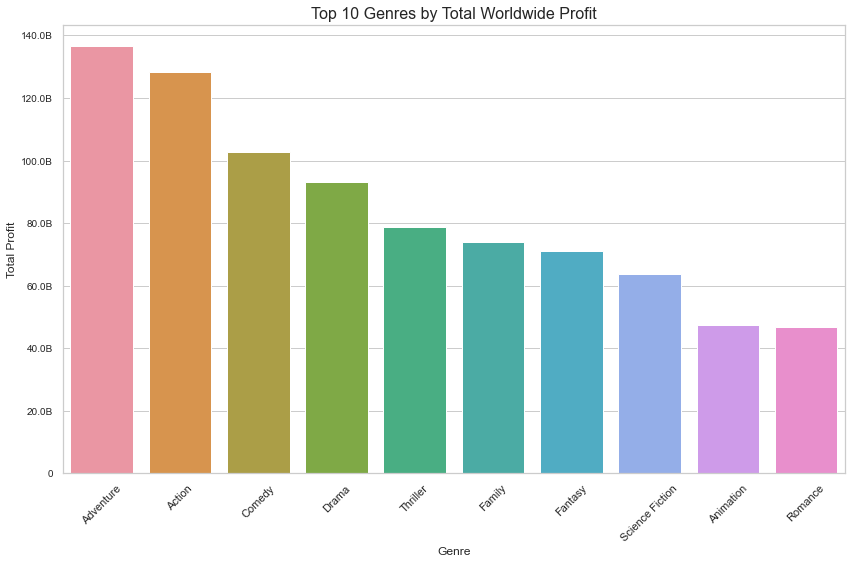

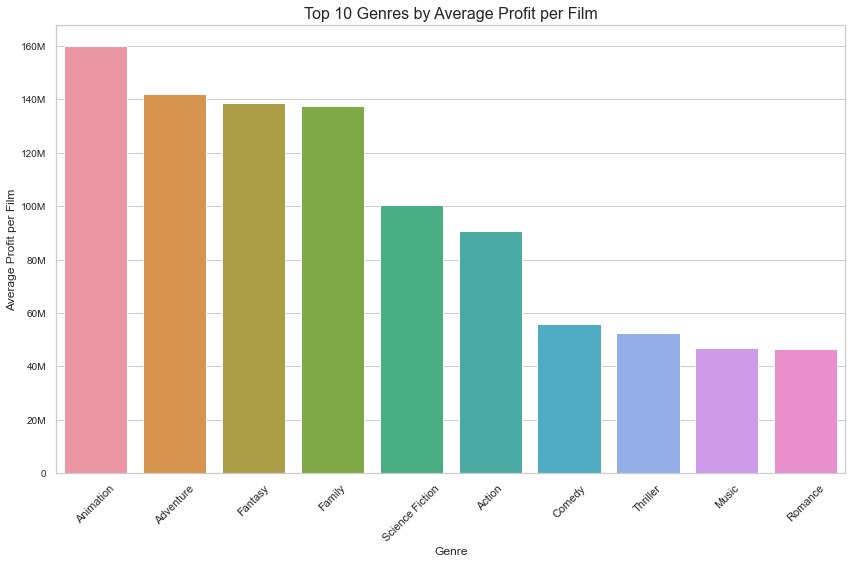

In [11]:
sns.set_theme(style="whitegrid") # so as to have a standard theme in the plots

# 1. Genre vs Profit (Total and Average) 
# Total Profit
genre_total_profit = df_exploded.groupby('Genres')['profit'].sum().sort_values(ascending=False).head(10)

# Average Profit
genre_avg_profit = df_exploded.groupby('Genres')['profit'].mean().sort_values(ascending=False).head(10)

# Plot1. Total Profit
plt.figure(figsize=(12,8))
sns.set_palette("crest")
sns.barplot(x=genre_total_profit.index, y=genre_total_profit.values)
plt.title('Top 10 Genres by Total Worldwide Profit', fontsize=16)
plt.xlabel('Genre')
plt.ylabel('Total Profit')
plt.gca().yaxis.set_major_formatter(billion_formatter)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('images/genre_total_profit.png')
plt.show()

# Plot 2: Average Profit
plt.figure(figsize=(12,8))
sns.set_palette("crest")
sns.barplot(x=genre_avg_profit.index, y=genre_avg_profit.values)
plt.title('Top 10 Genres by Average Profit per Film', fontsize=16)
plt.xlabel('Genre')
plt.ylabel('Average Profit per Film')
plt.gca().yaxis.set_major_formatter(million_formatter)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('images/genre_avg_profit.png')
plt.show()

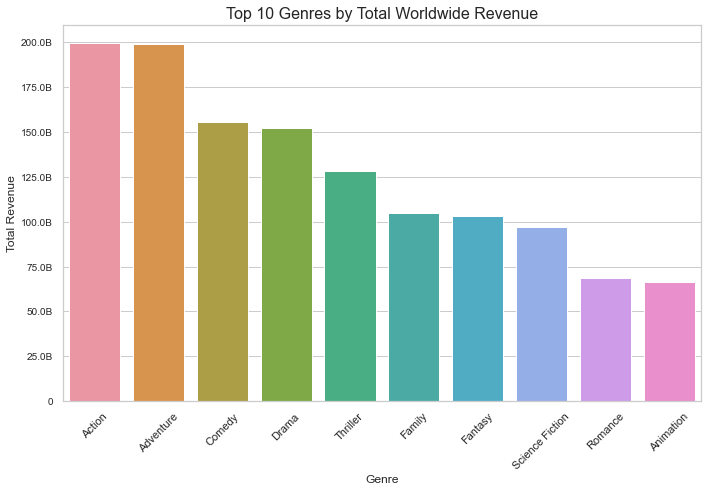

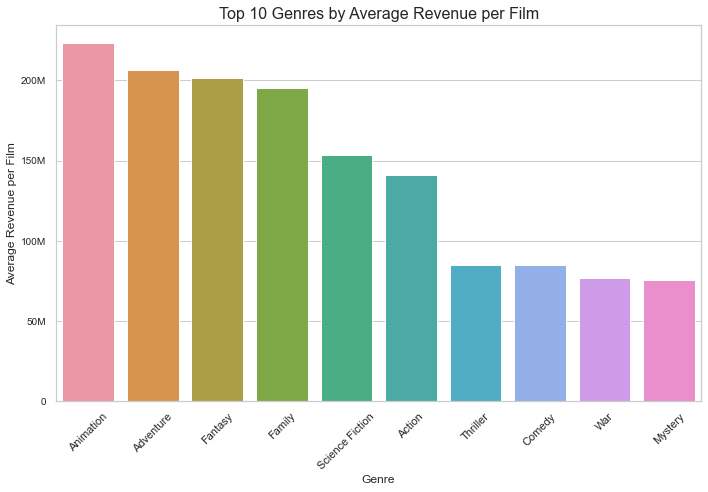

In [12]:
# 2 Genre vs Revenue (Total and Average)

# Total Revenue
genre_total_revenue = df_exploded.groupby('Genres')['revenue'].sum().sort_values(ascending=False).head(10)

# Average Revenue
# Re-calculate average on unique movies per genre to avoid skewing the average
# (Although df_exploded.groupby().mean() is statistically okay, this is conceptually cleaner)
unique_titles = df_genre.explode('Genres')
genre_avg_revenue = unique_titles.groupby('Genres')['revenue'].mean().sort_values(ascending=False).head(10)


# Plot 1: Total Revenue
plt.figure(figsize=(10,7))
sns.set_palette("crest")
sns.barplot(x=genre_total_revenue.index, y=genre_total_revenue.values)
plt.title('Top 10 Genres by Total Worldwide Revenue', fontsize=16)
plt.xlabel('Genre')
plt.ylabel('Total Revenue')
plt.gca().yaxis.set_major_formatter(billion_formatter)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('images/genre_vs_total_revenue.png')
plt.show()

 # Plot 2: Average Revenue
plt.figure(figsize=(10,7))
sns.set_palette("crest")
sns.barplot(x=genre_avg_revenue.index, y=genre_avg_revenue.values)
plt.title('Top 10 Genres by Average Revenue per Film', fontsize=16)
plt.xlabel('Genre')
plt.ylabel('Average Revenue per Film')
plt.gca().yaxis.set_major_formatter(million_formatter)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('images/genre_vs_revenue_avg.png')
plt.show()

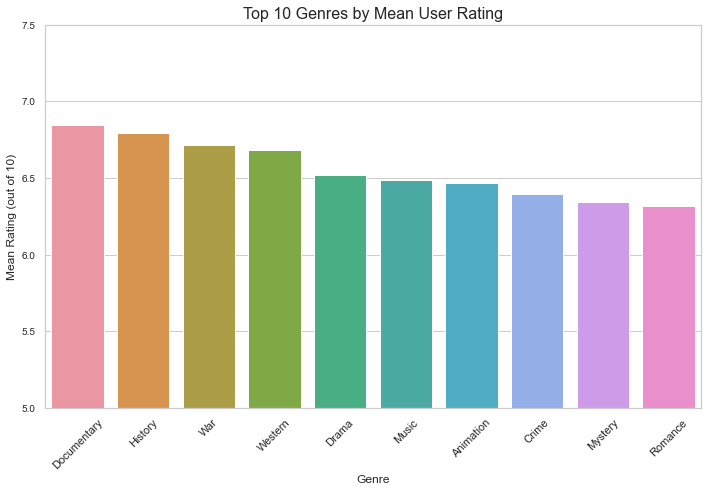

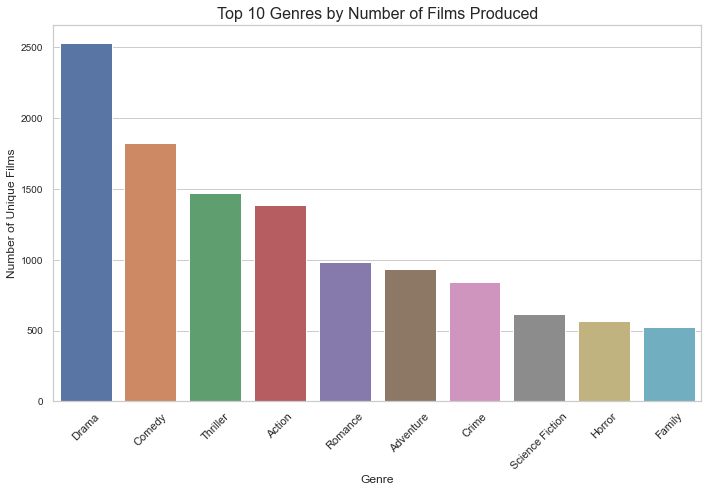

In [13]:
# 3 Genre vs Ratings (Mean Rating and Movie Count) 

# Mean Rating
genre_mean_rating = df_exploded.groupby('Genres')['vote_average'].mean().sort_values(ascending=False).head(10)

# Movie Count
genre_count = df_exploded.groupby('Genres')['movie_titles'].nunique().sort_values(ascending=False).head(10)

# Plot 1: Mean Rating
plt.figure(figsize=(10, 7))
sns.set_palette("flare")
sns.barplot(x=genre_mean_rating.index, y=genre_mean_rating.values)
plt.title('Top 10 Genres by Mean User Rating', fontsize=16)
plt.xlabel('Genre')
plt.ylabel('Mean Rating (out of 10)')
plt.xticks(rotation=45)
plt.ylim(5, 7.5)  
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('images/genre_vs_ratings_count.png')
plt.show()

    # Plot 2: Movie Count
plt.figure(figsize=(10, 7))
sns.set_palette("deep")
sns.barplot(x=genre_count.index, y=genre_count.values)
plt.title('Top 10 Genres by Number of Films Produced', fontsize=16)
plt.xlabel('Genre')
plt.ylabel('Number of Unique Films')
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('images/genre_vs_movie_count.png')
plt.show()

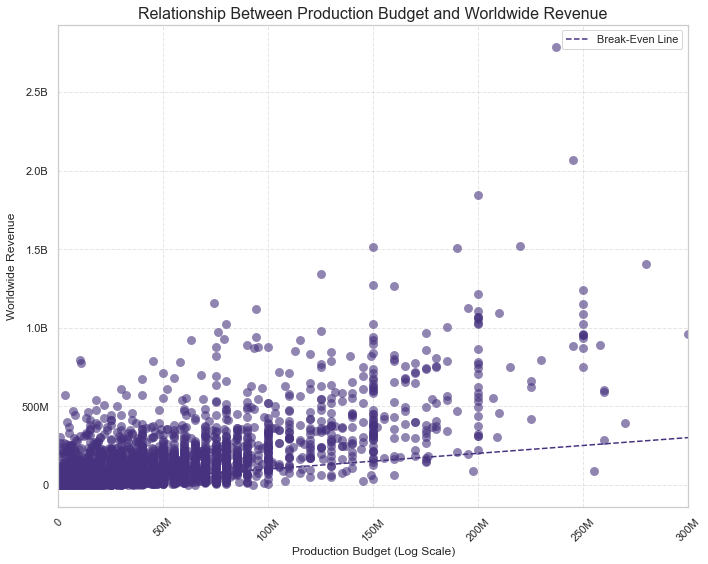

In [16]:
# 4 Budget vs Revenue 
df_plot = df.copy()

plt.figure(figsize=(10, 8))
sns.set_palette("viridis")
sns.scatterplot(
    x='production_budget',
    y='revenue',
    data=df_plot,
    alpha=0.6,
    s=80,
    linewidth=0
    )

# Break-even line
max_value = max(df_plot['production_budget'].max(), df_plot['revenue'].max())
plt.plot([1, max_value], [1, max_value], linestyle='--', label='Break-Even Line')

plt.title('Relationship Between Production Budget and Worldwide Revenue', fontsize=16)
plt.xlabel('Production Budget (Log Scale)')
plt.ylabel('Worldwide Revenue')

# Apply custom formatters
plt.gca().xaxis.set_major_formatter(billion_formatter)
plt.gca().yaxis.set_major_formatter(billion_formatter)
plt.tick_params(axis='x', rotation=45)

plt.xlim(0, 300_000_000)  # Show only budgets ≤ $300M
 
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('images/budget_vs_revenue.png')
plt.show()

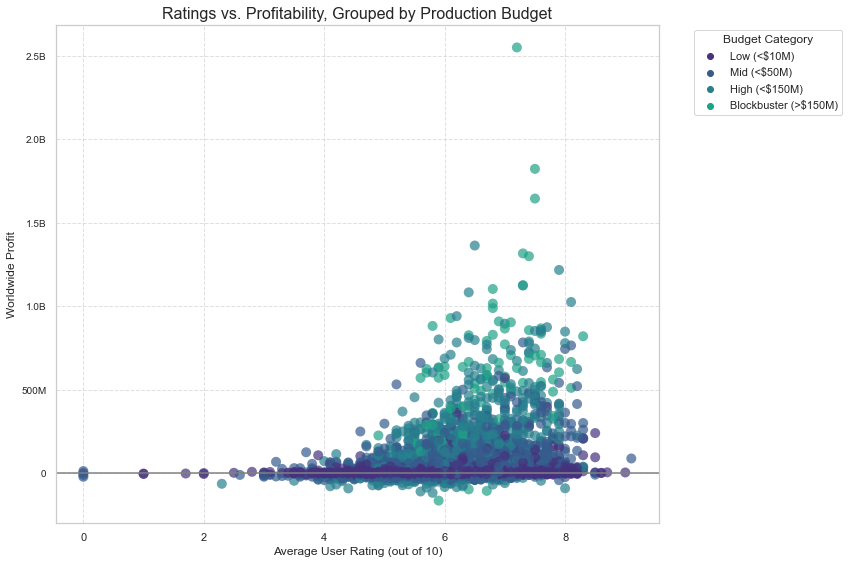

In [17]:
# 5 Ratings vs Profits ( Budget as Hue) 

df_plot = df.copy()

# Create a categorical budget size column for color coding
df_plot['Budget_Category'] = pd.cut(
    df_plot['production_budget'],
    bins=[-np.inf, 1e7, 5e7, 1.5e8, np.inf],
    labels=['Low (<$10M)', 'Mid (<$50M)', 'High (<$150M)', 'Blockbuster (>$150M)']
    )
# Scatter plot with Rating on X, Profit on Y, and Budget Category as Hue
plt.figure(figsize=(12, 8))
sns.set_palette("viridis")
sns.scatterplot(
    x='vote_average',
    y='profit',
    hue='Budget_Category',
    data=df_plot,
    alpha=0.7,
    s=100,
    linewidth=0,
    hue_order=['Low (<$10M)', 'Mid (<$50M)', 'High (<$150M)', 'Blockbuster (>$150M)']
)

# Draw a line at Profit = 0
plt.axhline(0, color='gray', linestyle='-')

plt.title('Ratings vs. Profitability, Grouped by Production Budget', fontsize=16)
plt.xlabel('Average User Rating (out of 10)')
plt.ylabel('Worldwide Profit')

# Apply custom formatter to Y-axis (Profit)
plt.gca().yaxis.set_major_formatter(billion_formatter)
plt.tick_params(axis='y', labelsize=10)

plt.legend(title='Budget Category',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('images/ratings_vs_profits_budget.png', dpi=300)
plt.show()


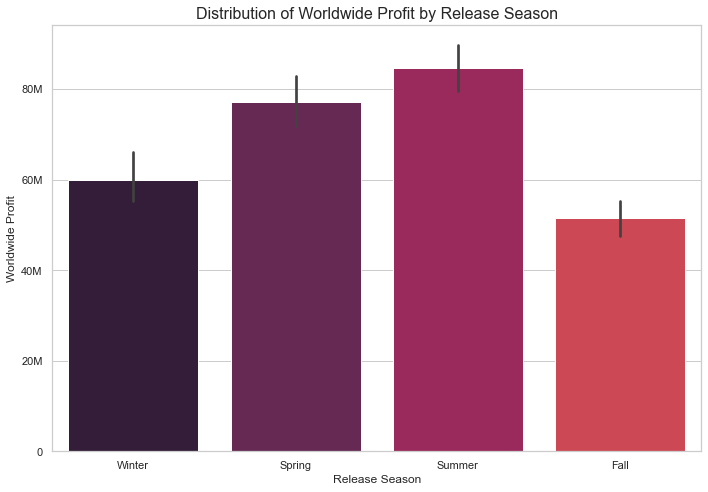

In [20]:
# 6 Seasons vs Profits

season_order = ['Winter', 'Spring', 'Summer', 'Fall']

plt.figure(figsize=(10, 7))
sns.set_palette("rocket")
sns.barplot(
        x='Season',
        y='profit',
        data=df_exploded,
        order=season_order,
    )

plt.title('Distribution of Worldwide Profit by Release Season', fontsize=16)
plt.xlabel('Release Season')
plt.ylabel('Worldwide Profit')

plt.gca().yaxis.set_major_formatter(billion_formatter)

plt.tight_layout()
plt.savefig('images/seasons_vs_profits.png')
plt.show()